<div style="display: flex; gap: 10px;">
  <img src="../images/HOOPS_AI.jpg" style="width: 20%;">
   

In [1]:
from IPython.display import Markdown, display
import inspect
import pathlib
import ast

def display_task_source(task_func, title):
    """Display task source code from the original file, including decorators but excluding docstrings.
    
    Only shows code from @flowtask decorator to end of function, excluding the function's docstring.
    """
    # Get the module where the function is defined
    module = inspect.getmodule(task_func)
    func_name = task_func.__name__
    
    if not module or not hasattr(module, '__file__'):
        display(Markdown(f"❌ Could not find source file for `{func_name}`"))
        return
    
    # Read the entire source file
    source_file = pathlib.Path(module.__file__)
    with open(source_file, 'r', encoding='utf-8') as f:
        file_content = f.read()
    
    # Parse the AST to find the function
    tree = ast.parse(file_content)
    
    # Find the function definition in the AST
    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef) and node.name == func_name:
            # Get line numbers (1-indexed)
            start_line = node.lineno
            end_line = node.end_lineno
            
            # Read the lines
            lines = file_content.splitlines()
            
            # Look backwards from function def to find @flowtask decorator
            decorator_start = start_line - 1  # Convert to 0-indexed
            while decorator_start > 0:
                line = lines[decorator_start - 1].strip()
                if line.startswith('@flowtask'):
                    break
                decorator_start -= 1
            
            # Extract from decorator to end of function
            source_lines = lines[decorator_start - 1:end_line]
            
            # Now remove the docstring if present
            # The docstring is the first statement in the function body
            if node.body and isinstance(node.body[0], ast.Expr) and isinstance(node.body[0].value, ast.Constant):
                if isinstance(node.body[0].value.value, str):
                    # Found a docstring - get its line range
                    docstring_start = node.body[0].lineno - 1  # Convert to 0-indexed
                    docstring_end = node.body[0].end_lineno - 1  # Convert to 0-indexed
                    
                    # Calculate relative positions in source_lines array
                    relative_doc_start = docstring_start - (decorator_start - 1)
                    relative_doc_end = docstring_end - (decorator_start - 1)
                    
                    # Remove docstring lines from source_lines
                    source_lines = source_lines[:relative_doc_start] + source_lines[relative_doc_end + 1:]
            
            source_code = '\n'.join(source_lines)
            
            # Display as markdown
            markdown_content = f"""---

### 📄 Task Source Code: `{func_name}`

```python
{source_code}
```
"""
            display(Markdown(markdown_content))
            return
    
    # Fallback if AST parsing fails
    display(Markdown(f"❌ Could not parse function `{func_name}` from source file"))


# HOOPS AI - Minimal ETL Demo

This notebook demonstrates the core features of the HOOPS AI data engineering workflows:

## Key Components
- **Schema-Based Dataset Organization**: Define structured data schemas for consistent data merging
- **Parallel Task Decorators**: Simplify CAD processing with type-safe task definitions
- **Generic Flow Orchestration**: Automatically handle task dependencies and data flow
- **Automatic Dataset Merging**: Process multiple files into a unified dataset structure
- **Integrated Exploration Tools**: Analyze and prepare data for ML workflows

The framework automatically generates visualization assets and stream cache data to support downstream applications.

In [2]:
import hoops_ai
import os

# Note: License is also set in cad_tasks.py for worker processes
# This is only for the parent process (optional but good practice)
hoops_ai.set_license(hoops_ai.use_test_license(), validate=False)

ℹ️ Using TEST LICENSE (expires December 8, 2025 - 37 days remaining)
   For production use, obtain your own license from Tech Soft 3D


## Import Dependencies

The HOOPS AI framework provides several key modules:
- `flowmanager`: Core orchestration engine with task decorators
- `cadaccess`: CAD file loading and model access utilities
- `storage`: Data persistence and retrieval components
- `dataset`: Tools for exploring and preparing merged datasets

In [3]:
import os
import pathlib
from typing import Tuple, List

# Import the flow builder framework from the library
import hoops_ai
from hoops_ai.flowmanager import flowtask


from hoops_ai.cadaccess import HOOPSLoader, HOOPSTools
from hoops_ai.cadencoder import BrepEncoder
from hoops_ai.dataset import DatasetExplorer
from hoops_ai.storage import DataStorage, CADFileRetriever, LocalStorageProvider
from hoops_ai.storage.datasetstorage.schema_builder import SchemaBuilder

## Configuration Setup

Define input and output paths for CAD processing:
- Input directory containing source CAD files 
- Output directory for processed results
- Source directory with specific CAD file formats

The framework will automatically organize outputs into structured directories.

In [4]:
# Configuration - Using simpler paths
nb_dir = pathlib.Path.cwd()

datasources_dir = nb_dir.parent.joinpath("packages","cadfiles","cadsynth100","step")

if not datasources_dir.exists():
    print("Data source directory does not exist. Please check the path.")
    exit(-1)

flows_outputdir = nb_dir.joinpath("out")


## Schema Definition - The Foundation of Dataset Organization

The `SchemaBuilder` defines a structured blueprint for how CAD data should be organized:
- **Domain & Version**: Namespace and versioning for schema tracking
- **Groups**: Logical data categories (e.g., "machining", "faces", "edges")  
- **Arrays**: Typed data containers with defined dimensions
- **Metadata Routing**: Rules for routing metadata to appropriate storage

Schemas ensure consistent data organization across all processed files, enabling automatic merging and exploration.

In [5]:
# Schema is now defined in cad_tasks.py for ProcessPoolExecutor compatibility
# Import it from there to view or customize
from cad_tasks import cad_schema
print(cad_schema)

{'version': '1.0', 'domain': 'Manufacturing_Analysis', 'groups': {'machining': {'primary_dimension': 'part', 'arrays': {'machining_category': {'dims': ['part'], 'dtype': 'int32', 'description': 'Machining complexity category (1-5)'}, 'material_type': {'dims': ['part'], 'dtype': 'int32', 'description': 'Material type (1-5)'}, 'estimated_machining_time': {'dims': ['part'], 'dtype': 'float32', 'description': 'Estimated machining time in hours'}}, 'description': 'Manufacturing and machining classification data'}}, 'description': 'Minimal schema for manufacturing classification', 'metadata': {'metadata': {'file_level': {}, 'categorical': {'material_type_description': {'dtype': 'str', 'required': False, 'description': 'Material classification'}}, 'routing_rules': {'file_level_patterns': [], 'categorical_patterns': ['material_type_description', 'category', 'type'], 'default_numeric': 'file_level', 'default_categorical': 'categorical', 'default_string': 'categorical'}}}}


In [6]:
# Import task functions from external module for ProcessPoolExecutor compatibility
from cad_tasks import gather_files, encode_manufacturing_data


In [7]:
display_task_source(gather_files, "gather_files")

---

### 📄 Task Source Code: `gather_files`

```python
@flowtask.extract(
    name="gather cad files",
    inputs=["cad_datasources"],
    outputs=["cad_dataset"],
    parallel_execution=True
)
def gather_files(source: str) -> List[str]:
    # Use simple glob pattern matching for ProcessPoolExecutor compatibility
    patterns = ["*.stp", "*.step", "*.iges", "*.igs"]
    source_files = []
    
    for pattern in patterns:
        search_path = os.path.join(source, pattern)
        files = glob.glob(search_path)
        source_files.extend(files)
    
    print(f"Found {len(source_files)} CAD files in {source}")
    return source_files
```


In [8]:
display_task_source(encode_manufacturing_data, "encode_manufacturing_data")

---

### 📄 Task Source Code: `encode_manufacturing_data`

```python
@flowtask.transform(
    name="Manufacturing data encoding",
    inputs=["cad_dataset"],
    outputs=["cad_files_encoded"],
    parallel_execution=True
)
def encode_manufacturing_data(cad_file: str, cad_loader: HOOPSLoader, storage: DataStorage) -> str:
    # Load CAD model using the process-local HOOPSLoader
    cad_model = cad_loader.create_from_file(cad_file)
    
    # Set the schema for structured data organization
    # Schema is defined at module level, so it's available in all worker processes
    storage.set_schema(cad_schema)
    
    # Prepare BREP for feature extraction
    hoopstools = HOOPSTools()
    hoopstools.adapt_brep(cad_model, None)
    
    # Extract geometric features using BrepEncoder
    brep_encoder = BrepEncoder(cad_model.get_brep(), storage)
    brep_encoder.push_face_indices()
    brep_encoder.push_face_attributes()
    
    # Generate manufacturing classification data
    file_basename = os.path.basename(cad_file)
    file_name = os.path.splitext(file_basename)[0]
    
    # Set seed for reproducible results based on filename
    random.seed(hash(file_basename) % 1000)
    
    # Generate classification values
    machining_category = random.randint(1, 5)
    material_type = random.randint(1, 5)
    estimated_time = random.uniform(0.5, 10.0)
    
    # Material type descriptions
    material_descriptions = ["Steel", "Aluminum", "Titanium", "Plastic", "Composite"]
    
    # Save data using the OptStorage API (data_key format: "group/array_name")
    storage.save_data("machining/machining_category", np.array([machining_category], dtype=np.int32))
    storage.save_data("machining/material_type", np.array([material_type], dtype=np.int32))
    storage.save_data("machining/estimated_machining_time", np.array([estimated_time], dtype=np.float32))
    
    # Save categorical metadata (will be routed to .attribset)
    storage.save_metadata("material_type_description", material_descriptions[material_type - 1])
    
    # Save file-level metadata (will be routed to .infoset)
    storage.save_metadata("Item", str(cad_file))
    storage.save_metadata("Flow name", "minimal_manufacturing_flow")
    
    # Compress the storage into a .data file
    storage.compress_store()

    
    return storage.get_file_path("")
```


## Flow Orchestration and Automatic Dataset Generation

The `hoops_ai.create_flow()` function orchestrates the data flow execution

In [9]:
# Create and run the Data Flow
flow_name = "minimal_manufacturing_flow"  
cad_flow = hoops_ai.create_flow(
    name=flow_name,
    tasks=[gather_files, encode_manufacturing_data],  # Imported from cad_tasks.py
    max_workers=12,  # Process-based parallel execution now works!
    flows_outputdir=str(flows_outputdir),
    ml_task="Manufacturing Classification Demo",
    auto_dataset_export=True,  # Enable automatic dataset merging
    debug=False  # Changed to False to enable parallel execution
)

# Run the flow to process all files
print("Starting flow execution with ProcessPoolExecutor...")
print("✓ Schema is defined in cad_tasks.py, available to all worker processes")
flow_output, output_dict, flow_file = cad_flow.process(inputs={'cad_datasources': [str(datasources_dir)]})

# Display results
print("\n" + "="*70)
print("FLOW EXECUTION COMPLETED SUCCESSFULLY")
print("="*70)
print(f"\nDataset files created:")
print(f"  Main dataset: {output_dict.get('flow_data', 'N/A')}")
print(f"  Info dataset: {output_dict.get('flow_info', 'N/A')}")
print(f"  Attributes: {output_dict.get('flow_attributes', 'N/A')}")
print(f"  Flow file: {flow_file}")
print(f"\nTotal processing time: {output_dict.get('Duration [seconds]', {}).get('total', 0):.2f} seconds")
print(f"Files processed: {output_dict.get('file_count', 0)}")

Starting flow execution with ProcessPoolExecutor...
✓ Schema is defined in cad_tasks.py, available to all worker processes
|INFO| FLOW | ######### Flow 'minimal_manufacturing_flow' start #######
|WARNING| FLOW | Cleaning up existing flow directory: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\minimal_manufacturing_flow
|WARNING| FLOW | Removing all previous outputs for flow 'minimal_manufacturing_flow' to avoid build conflicts.
|INFO| FLOW | Flow directory successfully cleaned and recreated: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\minimal_manufacturing_flow
|INFO| FLOW | 
Flow Execution Summary
|INFO| FLOW | ==================================================
|INFO| FLOW | Task 1: gather cad files
|INFO| FLOW |     Inputs : cad_datasources
|INFO| FLOW |     Outputs: cad_dataset
|INFO| FLOW | Task 2: Manufacturing data encoding
|INFO| FLOW |     Inputs : cad_dataset
|INFO| FLOW |     Outputs: c

DATA INGESTION:   0%|                                                                            | 0/1 [00:00<…

|INFO| FLOW | Executing ParallelTask 'Manufacturing data encoding' with 101 items.


DATA TRANSFORMATION:   0%|                                                                     | 0/101 [00:00<…

|INFO| FLOW | Executing SequentialTask 'AutoDatasetExportTask'.
[DatasetMerger] Saved schema with 2 groups to metadata.json
|INFO| FLOW | Auto dataset export completed in 35.81 seconds
Sequential Task end=====================
|INFO| FLOW | Time taken: 217.68 seconds
|INFO| FLOW | ######### Flow 'minimal_manufacturing_flow' end ######

FLOW EXECUTION COMPLETED SUCCESSFULLY

Dataset files created:
  Main dataset: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\minimal_manufacturing_flow\minimal_manufacturing_flow.dataset
  Info dataset: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\minimal_manufacturing_flow\minimal_manufacturing_flow.infoset
  Attributes: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\minimal_manufacturing_flow\minimal_manufacturing_flow.attribset
  Flow file: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out/

# DATA SERVING : Use the DatasetExplorer to navigate your data

In [10]:
# Explore the generated dataset
explorer = DatasetExplorer(flow_output_file=str(flow_file))
explorer.print_table_of_contents()

[DatasetExplorer] Default local cluster started: <Client: 'tcp://127.0.0.1:64364' processes=1 threads=16, memory=7.45 GiB>


Processing file info:   0%|          | 0/101 [00:00<?, ?it/s]


--- Dataset Table of Contents ---

FACES_GROUP:
  FACE_AREAS_DATA: Shape: (2796,), Dims: ('face',), Size: 2796
  FACE_INDICES_DATA: Shape: (2796,), Dims: ('face',), Size: 2796
  FACE_LOOPS_DATA: Shape: (2796,), Dims: ('face',), Size: 2796
  FACE_TYPES_DATA: Shape: (2796,), Dims: ('face',), Size: 2796
  FILE_ID_CODE_FACES_DATA: Shape: (2796,), Dims: ('face',), Size: 2796

MACHINING_GROUP:
  ESTIMATED_MACHINING_TIME_DATA: Shape: (101,), Dims: ('machining_estimated_machining_time_dim_0',), Size: 101
  FILE_ID_CODE_MACHINING_DATA: Shape: (101,), Dims: ('machining_estimated_machining_time_dim_0',), Size: 101
  MACHINING_CATEGORY_DATA: Shape: (101,), Dims: ('machining_estimated_machining_time_dim_0',), Size: 101
  MATERIAL_TYPE_DATA: Shape: (101,), Dims: ('machining_estimated_machining_time_dim_0',), Size: 101
Columns in file_info:
                                 name   id                             description                   flow_name                        stream_cache_png           

## ML-Ready Dataset Preparation

The `DatasetLoader` provides tools for preparing the merged dataset for machine learning:

### Key Capabilities:
- **Stratified Splitting**: Create train/validation/test splits while preserving class distributions
- **Subset Tracking**: Records file assignments in the dataset metadata

In [11]:
# Load and split dataset for machine learning
from hoops_ai.dataset import DatasetLoader

flow_path = pathlib.Path(flow_file)
loader = DatasetLoader(
    merged_store_path=str(flow_path.parent / f"{flow_path.stem}.dataset"),  
    parquet_file_path=str(flow_path.parent / f"{flow_path.stem}.infoset")
)

# Split dataset by machining category with explicit group parameter
train_size, val_size, test_size = loader.split(
    key="machining_category",
    group="machining",  # Explicitly specify the group for clarity
    train=0.6, 
    validation=0.2, 
    test=0.2, 
    random_state=42
)

print(f"Dataset split: Train={train_size}, Validation={val_size}, Test={test_size}")

# Access training dataset
train_dataset = loader.get_dataset("train")
print(f"Training dataset ready with {len(train_dataset)} samples")

loader.close_resources()

[DatasetExplorer] Default local cluster started: <Client: 'tcp://127.0.0.1:62863' processes=1 threads=16, memory=7.45 GiB>


Processing file info:   0%|          | 0/101 [00:00<?, ?it/s]


DATASET STRUCTURE OVERVIEW

Group: faces
------------------------------
  face_areas: (2796,) (float32)
  face_indices: (2796,) (int32)
  face_loops: (2796,) (int32)
  face_types: (2796,) (int32)
  file_id_code_faces: (2796,) (int64)

Group: machining
------------------------------
  estimated_machining_time: (101,) (float32)
  file_id_code_machining: (101,) (int64)
  machining_category: (101,) (float64)
  material_type: (101,) (float64)

DEBUG: file_codes type: <class 'numpy.ndarray'>, shape: (101,)
DEBUG: file_codes range: 0 to 100
DEBUG: first 10 file_codes: [0 1 2 3 4 5 6 7 8 9]
DEBUG: df_info columns: ['name', 'id', 'description', 'flow_name', 'stream_cache_png', 'stream_cache_3d', 'subset', 'table_name']
DEBUG: df_info shape: (101, 8)
DEBUG: existing IDs type: <class 'str'>
DEBUG: first 10 existing IDs: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
DEBUG: existing IDs range: 0 to 99
DEBUG: file_codes appear to be indices, mapping to actual IDs...
DEBUG: Mapped 101 indices to 101 IDs

## Summary: The HOOPS AI - Data Flow Advantage

This minimal example demonstrates how HOOPS AI simplifies CAD data processing for ML:

1. **Schema-First Approach**: Define your data structure before processing
2. **Decorator-Based Tasks**: Easily inject custom processing logic
3. **Automatic Orchestration**: Let the framework handle execution complexity
4. **Unified Dataset**: Get consistently merged data ready for ML
5. **Built-in Exploration**: Analyze and prepare datasets with powerful tools

The framework automatically generates visualization assets and stream caches, making it easy to integrate with downstream visualization tools.

In [12]:
# Visualization libraries
import matplotlib.pyplot as plt

def print_distribution_info(dist, title="Distribution"):
    """Helper function to print and visualize distribution data."""
    list_filecount = list()
    for i, bin_files in enumerate(dist['file_id_codes_in_bins']):
        list_filecount.append(bin_files.size)

    dist['file_count'] =list_filecount
    # Visualization with matplotlib
    fig, ax = plt.subplots(figsize=(12, 4))
    
    bin_centers = 0.5 * (dist['bin_edges'][1:] + dist['bin_edges'][:-1])
    ax.bar(bin_centers, dist['file_count'], width=(dist['bin_edges'][1] - dist['bin_edges'][0]), 
           alpha=0.7, color='steelblue', edgecolor='black', linewidth=1)
    
    # Add file count annotations
    for i, count in enumerate(dist['file_count']):
        if count > 0:  # Only annotate non-empty bins
            ax.text(bin_centers[i], count + 0.5, f"{count}", 
                    ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.set_title(f'{title} Histogram')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

Material distribution created in 1.77 seconds



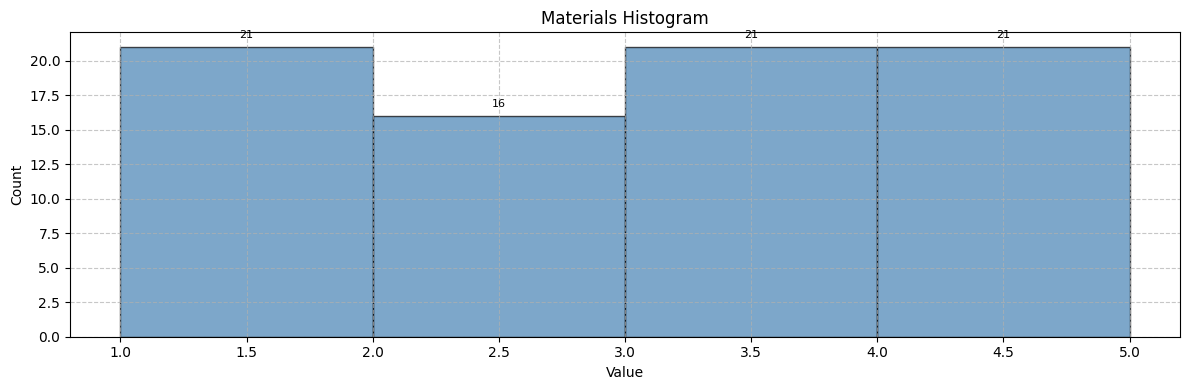

In [13]:
import time
start_time = time.time()
face_dist = explorer.create_distribution(key="machining_category", bins=None, group="machining")
print(f"Material distribution created in {(time.time() - start_time):.2f} seconds\n")
print_distribution_info(face_dist, title="Materials")

## Dataset Visualization with DatasetViewer

The **DatasetViewer** is a powerful visualization tool that bridges dataset queries and visual analysis. It enables you to quickly visualize query results in two ways:

1. **Image Grids**: Generate collages of PNG previews for rapid visual scanning
2. **Interactive 3D Views**: Open inline 3D viewers for detailed model inspection

In [14]:
# Import the DatasetViewer from the insights module
from hoops_ai.insights import DatasetViewer

# Create a DatasetViewer using the convenience method from_explorer
# This method queries the explorer and builds the file ID to visualization path mappings
dataset_viewer = DatasetViewer.from_explorer(explorer)

2025-10-31 19:51:30 | INFO | hoops_ai.insights.dataset_viewer | Built file mapping for 101 files


In [15]:
start_time = time.time()

# condition
material_is_frequent = lambda ds: ds['material_type'] == 2

filelist = explorer.get_file_list(group="machining", where=material_is_frequent)
print(f"Filtering completed in {(time.time() - start_time):.2f} seconds")
print(filelist)

Filtering completed in 0.11 seconds
[  0   9  10  14  21  28  32  33  35  45  49  52  78  80  87 100]


### Example 1: Visualize Query Results as Image Grid

Now let's use the query results we obtained earlier and visualize them as a grid of images. This is perfect for quickly scanning through many files to understand patterns or identify specific cases.

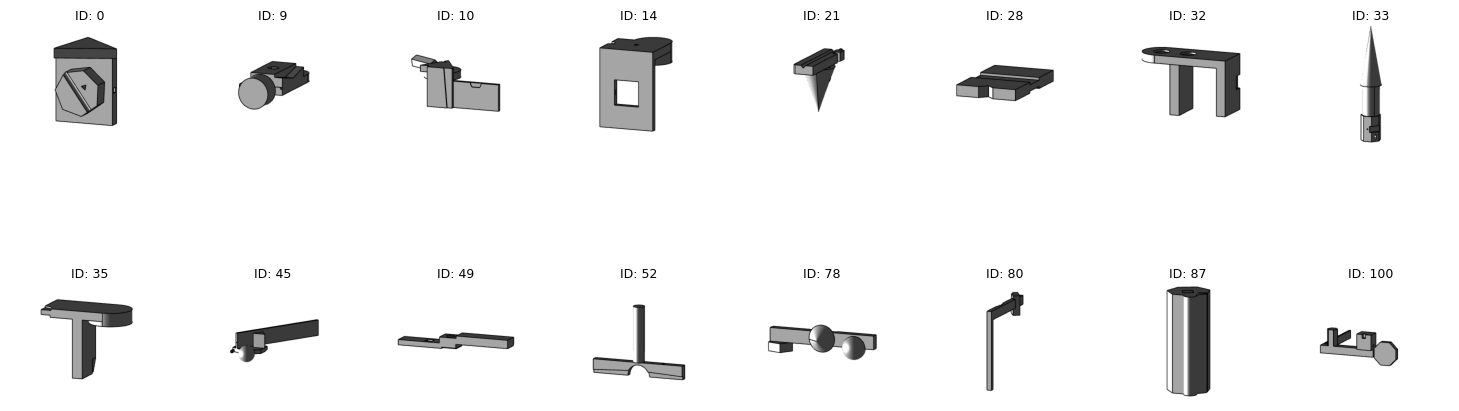

In [16]:
# Visualize the filtered files as a 5x5 grid with file IDs as labels
fig = dataset_viewer.show_preview_as_image(
    filelist, 
    k=len(filelist),                      # Show up to 25 files
    grid_cols=8,               # 5 columns
    label_format='id',         # Show file IDs as labels
    figsize=(15, 5)           # Larger figure size
)

plt.show()